## **3.8 Effect of Optimizer**

100%|██████████| 170498071/170498071 [00:02<00:00, 81081765.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


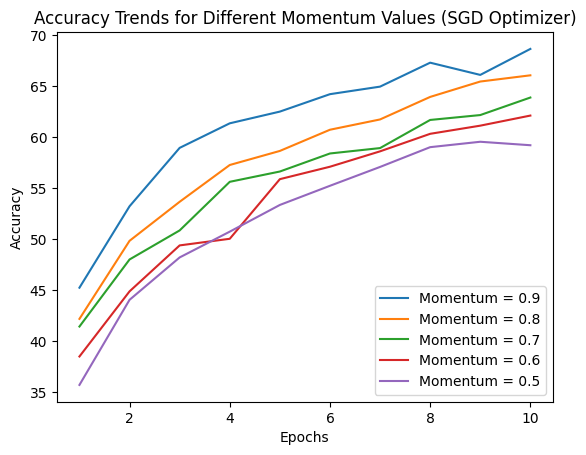

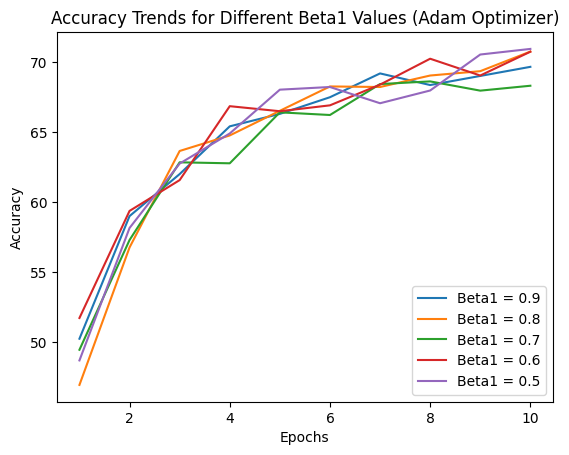

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load datasets
train_dataset_CIFAR10 = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset_CIFAR10 = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Create data loaders
train_loader_CIFAR10 = torch.utils.data.DataLoader(train_dataset_CIFAR10, batch_size=64, shuffle=True)
test_loader_CIFAR10 = torch.utils.data.DataLoader(test_dataset_CIFAR10, batch_size=64, shuffle=False)

# Define functions to train and evaluate the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    accuracies = []
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        accuracy = evaluate_model(model, test_loader_CIFAR10)
        accuracies.append(accuracy)
    return accuracies

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Momentum values for SGD
momentum_values = [0.9, 0.8, 0.7, 0.6, 0.5]

# Beta1 values for Adam
beta1_values = [0.9, 0.8, 0.7, 0.6, 0.5]

# Number of epochs
num_epochs = 10

# Store accuracy trends
accuracy_trends_sgd = []
accuracy_trends_adam = []

# Train and evaluate the model using SGD optimizer with different momentum values
for momentum in momentum_values:
    cnn = SimpleCNN()
    optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=momentum)
    accuracies = train_model(cnn, train_loader_CIFAR10, criterion, optimizer, num_epochs)
    accuracy_trends_sgd.append(accuracies)

# Train and evaluate the model using Adam optimizer with different beta1 values
for beta1 in beta1_values:
    cnn = SimpleCNN()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(beta1, 0.999))
    accuracies = train_model(cnn, train_loader_CIFAR10, criterion, optimizer, num_epochs)
    accuracy_trends_adam.append(accuracies)

# Plot the accuracy trends for SGD
for i, momentum in enumerate(momentum_values):
    plt.plot(range(1, num_epochs + 1), accuracy_trends_sgd[i], label=f'Momentum = {momentum}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trends for Different Momentum Values (SGD Optimizer)')
plt.legend()
plt.show()

# Plot the accuracy trends for Adam
for i, beta1 in enumerate(beta1_values):
    plt.plot(range(1, num_epochs + 1), accuracy_trends_adam[i], label=f'Beta1 = {beta1}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trends for Different Beta1 Values (Adam Optimizer)')
plt.legend()
plt.show()
